# Community Solar Hardware Recommender

## Overview
Returns hardware recommendations based on a few different goals

### Current Gaps
* filter hardware list, but by what? top 50%? Which is the most important characteristic?
* hardware inneficiencies
* confirm that the NREL model is based off of the weather file and that encompasses overcast chance
* change in cost of electricity from grid (and inflation) over time (see NREL levelized cost calculator
* include participation rate

### Things not included in the model
* Aggregator operational costs are not included here. The results of this study can be used for further research to attempt to design an aggregation service that can function within these parameters

## Psuedo Code

Inputs:
* Location
* Range of PV and Battery options
* Cost estimates
* Network info
* shading on an hourly basis

1) Get hourly irradiance from NREL
2) loop through every possible PV and battery combo and determine:
    * estimated hardware costs
    * estimated annual PV Wh generation (does it get curtailed if it exceeds battery capacity)?
    * maximum automated DR participation (combines battery capacity and SOA during event windows)
    * calculates ROI
3) Remove options that don't break even within 7 years from data set
4) graph all data
5) identify:
    * hardware combination with quickest ROI
    * largest PV system within 8 year ROI
    * largest Battery system within 7 year ROI
    * largest overall system within 7 year ROI
    * system with largest avoided grid consumption
    * system with largest automated DR event participation
    
## Variations to Test

* only best hardware 
    * w to wh
    * $ per wh
* only worst hardware
* afternoon call times

In [778]:
import pandas as pd
from matplotlib import pyplot as plt
import requests
import math

In [779]:
#Max Hardware Sizes
pvMaxW = 500
batMaxWh = 2000

shading = .9

#equipment derating -> charge controller efficiency etc
equipDerating = .99

totDerating = equipDerating * shading

### Commercially Available Hardware Data

In [780]:
# read in hardware data to dataframe

hardware_df = pd.read_csv('data/DER-Hardware-November-LiFePo4-batteriespowerstations-updated-NOV12.csv')

hardware_df.head()

,Make,Model,Battery Wh,Max PV Watt,W to Wh ratio,Min PV Voltage,Max PV Voltage,Max PV Amps,Inverter Watts,Grid Charge Watts,...,Battery Type,Retail Price (11/12/2023),Price per Wh,Pass Through Charging,Smart Control,Warranty Years,Cycles,DoD,Lifespan,Link
0,Jackery,Explorer 1000 Plus Portable Power Station,1264.64,800,0.632591,NaN,NaN,NaN,2000,NaN,...,LiFePO4,899.00,0.71,False,False,3.0,4000,70,NaN,https://www.jackery.com/products/jackery-explo...
1,Jackery,Explorer 2000 Plus Portable Power Station,2042.80,1400,0.685334,NaN,NaN,NaN,3000,NaN,...,LiFePO4,"1,659.00",0.81,False,False,NaN,4000,70,NaN,https://www.jackery.com/products/explorer-2000...
2,Pecron,Portable Power Station,614.00,400,0.651466,12.0,18.0,7.0,1200,NaN,...,LiFePO4,299.00,0.49,False,False,2.0,3500,80,NaN,https://www.pecron.com/products/pecron-e600lfp...
3,Pecron,E1500LFP Expandable Power Station,1536.00,800,0.520833,12.0,18.0,7.0,2200,NaN,...,LiFePO4,899.00,0.59,False,False,2.0,3500,80,NaN,https://www.pecron.com/products/pecron-e1500lf...
4,Pecron,E2000LFP Expandable Portable Power Station,1920.00,1200,0.625000,12.0,18.0,7.0,2000,NaN,...,LiFePO4,899.00,0.47,False,False,2.0,3500,80,NaN,https://www.pecron.com/products/pecron-e2000lf...


Total Number of Companies: 15
Total Number of Products: 37


<AxesSubplot:xlabel='W to Wh ratio', ylabel='Price per Wh'>

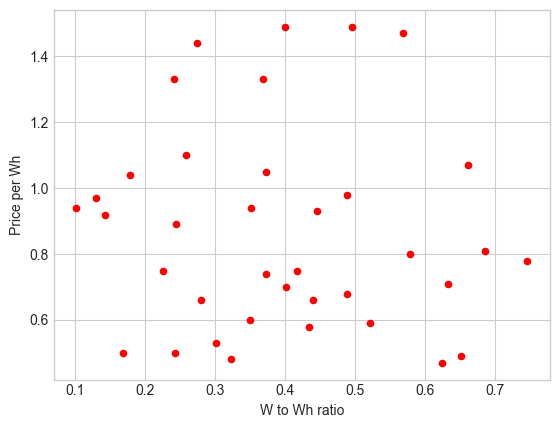

In [781]:
# data snapshot
print('Total Number of Companies: ' + str(hardware_df.drop_duplicates(subset=['Make']).shape[0]))
print('Total Number of Products: ' + str(hardware_df.shape[0]))

hardware_df.plot(kind = 'scatter', x = 'W to Wh ratio', y = 'Price per Wh', c='red',colormap='viridis')


In [782]:
# filter hardware list

#remove rows with W to Wh ratios < .25
fhardware_df = hardware_df[(hardware_df['W to Wh ratio'] > .2)]

#remove rows with price per Wh > 1.0
fhardware_df = fhardware_df[(fhardware_df['Price per Wh'] <= 1.2)]

# data snapshot
print('Total Number of Companies: ' + str(fhardware_df.drop_duplicates(subset=['Make']).shape[0]))
print('Total Number of Products: ' + str(fhardware_df.shape[0]))

fhardware_df = hardware_df

Total Number of Companies: 14
Total Number of Products: 26


<AxesSubplot:xlabel='W to Wh ratio', ylabel='Price per Wh'>

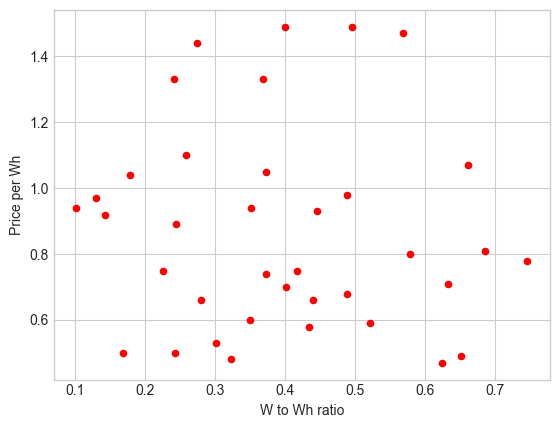

In [783]:
fhardware_df.plot(kind = 'scatter', x = 'W to Wh ratio', y = 'Price per Wh', c='red',colormap='viridis')

In [784]:
#80% depth of discharge for LiFePO4 batteries
LiFePOdod = fhardware_df['DoD'].median()*.01
print("Median LiFePO4 DoD: " + str(LiFePOdod))

# check against list of hardware
inverterEfficiency = .96

# check against list of hardware
# not currently used in model
gridChargingEfficiency = .96

#battery W to Wh ratio
batPVcapacity = fhardware_df['W to Wh ratio'].median()
print('W to Wh median: ' + str(batPVcapacity))

avgBatCycles = round(fhardware_df['Cycles'].median())
print('Median battery cycles: ' + str(avgBatCycles) + " (" + str(round(avgBatCycles/365/.01)*.01) + " years)")

batteryDollarPerWh = math.floor(fhardware_df['Price per Wh'].median()*100)*.01
print('$ per Wh median: ' + str(batteryDollarPerWh) + " dollars for 1 Wh")

Median LiFePO4 DoD: 0.8
W to Wh median: 0.3724394786
Median battery cycles: 3100 (8.49 years)
$ per Wh median: 0.8 dollars for 1 Wh


In [785]:
#DR variables
CSRPratePerkW = 18
DLRPratePerkW = 18

#not currently used in this model
CSRPperfRatePerkW = 1

#this is the monthly reservation payment
totDRratePerkW = CSRPratePerkW + DLRPratePerkW

In [786]:
#PV Installation Details
lat = 40.7128
long = 74.0060

#seasonal tilt options: summer, winter, average
season = 'summer'


In [787]:
 def pvWattsRequest(lat, season):
        
    if season == 'summer':
        s = -15
    elif season == 'winter':
        s = 15
    else:
        s = 0
        
    # api documentation: https://developer.nrel.gov/docs/solar/pvwatts/v8/#request-url
    nAzimuth = str(170); #cardinal direction
    nCapkW = str(.05); #nameplate capacity minimum 0.05*
    nLat = str(lat); #latitude
    nTilt = str(lat + s); #priotized for summer
    nLosses = str(shading * equipDerating); #derating*
    nInvEff = str(inverterEfficiency * 100); #inverter efficiency*
    nBorough = 'manhattan' #this data should come from the network list ultimately
    nTimeframe = 'hourly'
    nrelKey = 'oAhJWNZJSMfoZqx83MMOV1pYheWkAi2Z2XVn59UT'
    getURL = 'https://developer.nrel.gov/api/pvwatts/v8.json?api_key=' + nrelKey + '&azimuth=' + nAzimuth+'&system_capacity=' + nCapkW +'&losses=' + nLosses +'&array_type=1&module_type=0&inv_eff=' + nInvEff + '&tilt=' +  nTilt +'&address=' + nBorough +',ny&timeframe=' + nTimeframe

    print(getURL)
    return getURL

#we care about hourly plane of array irradiance (POA)
# we can also get hourly DC output, but we'll quickly exceed the 1000 calls an hour max...
# *doesn't impact POA

nrelData = requests.get(pvWattsRequest(lat, season)).json()['outputs']
print(nrelData)

https://developer.nrel.gov/api/pvwatts/v8.json?api_key=oAhJWNZJSMfoZqx83MMOV1pYheWkAi2Z2XVn59UT&azimuth=170&system_capacity=0.05&losses=0.891&array_type=1&module_type=0&inv_eff=96.0&tilt=25.7128&address=manhattan,ny&timeframe=hourly
{'ac_monthly': [4.887987081700259, 5.451239195524138, 6.42801304623899, 7.158826932997118, 7.710913402355009, 7.792189851730654, 8.042116798123912, 7.42721173438306, 6.77380153570628, 5.575515180037597, 4.292454455988033, 3.943717325674179], 'poa_monthly': [98.61403650172664, 112.9607077624791, 139.6171340868954, 156.8364403526696, 174.2376350850779, 179.4767476622332, 187.7095021228868, 174.0208174800289, 154.0629227619962, 120.6265612681154, 89.59338237140902, 79.74561766761994], 'solrad_monthly': [3.181097951668602, 4.03431099151711, 4.503778518932108, 5.227881345088987, 5.620568873712189, 5.982558255407772, 6.055145229770541, 5.613574757420287, 5.135430758733207, 3.891179395745657, 2.986446079046968, 2.572439279600643], 'dc_monthly': [5.119835340306318,

In [788]:
#Annual PV Production w/ 50W module

print('Estimated annual AC production with 50W module (they are all different):')

#multiply this by PV module size
# DC output = annual daily sun hour average * 365 days * cc efficiency * shade losses * module W
# AC output = DC output * inverter efficiency
print('ac_annual kW NREL: ' + str(nrelData['ac_annual']))

dailyAvgRad = nrelData['solrad_annual']

#this is what we use when we calculate all our options...
dcOutputFactors = dailyAvgRad * 365 * equipDerating * shading

#convert to kW
print('ac annual kW calculated from annual average radiation: ' + str(dcOutputFactors * 50 * .001 * inverterEfficiency))

#yet another way to calculate annaul AC output
print('ac annual kW calculated from predicted monthly DC output:' + str(sum(nrelData['dc_monthly'])*inverterEfficiency))

hourlyPOA = nrelData['poa']
hourlyDC = nrelData['dc']

#print(hourlyPOA)'''

Estimated annual AC production with 50W module (they are all different):
ac_annual kW NREL: 75.48398654045928
ac annual kW calculated from annual average radiation: 71.29286666147281
ac annual kW calculated from predicted monthly DC output:76.25395732995966


In [789]:
# GRID ELECTRICITY COSTS
def avoidedUtilityCosts(generatedkWAC):
    supplyChargeDollarsPerkWh = .09453
    deliveryChargeDollarsPerkWh = .15653
    systemBenefitChargeDollarsPerkWh = .00520
    salesTax = .045
    gridDollarPerkW = (supplyChargeDollarsPerkWh + deliveryChargeDollarsPerkWh + systemBenefitChargeDollarsPerkWh) * (1 + salesTax)
    #print("Con Ed $ per kWh = " + str(gridDollarPerkW))

    annualAvoidedCosts = generatedkWAC * gridDollarPerkW
    
    return annualAvoidedCosts

In [790]:
# HARDWARE COSTS

'''
I'm looking levelized cost - see NREL's report
'''

def hardwareCosts(pvW, batWh):
    #variable hardware costs
    # average cost of LiFePO4 batteries currently on market
    bPerWh = batteryDollarPerWh
    # average cost of PV modules per kW
    pvDollarPerW = 1.0
    mountDollarPerW = .4
    variableCosts = pvW * (bPerWh + pvDollarPerW + mountDollarPerW) 

    #fixed costs
    bosCost = 10 #bos includes cables, insulation when bringing cables in probably via window
    smartController = 100
    operatingCosts = 0 #DR aggregation operator costs are not considered here. 
    fixedHardwareCosts = bosCost + smartController + operatingCosts

    c = fixedHardwareCosts + (pvW * pvDollarPerW) + (batWh * bPerWh)
    return c

In [791]:
#Max automated battery + PV generation during event windows from May through September
#assumes battery is fully charged (from either PV or grid) at start of event
#returns average hourly commitment i.e. reservation amount in watts
def maxDRParticipation(batWh, pvW):
    batteryACOutput = batWh * LiFePOdod * inverterEfficiency * .25
    
    runningTot = 0

    #days in the months May - September
    #daysInMonth = [31,30,31,31,30]
    
    #returns average PV generated for all window hours
    #Get all the DR event window hours from May 1st (day #121) through September 30th (day # 273)
    for d in range(121, 274):
        drEventWindowPOA = 0
        drEventDCWh = 0
        for e in range(11,15):
            #POA for 1 hour during the event window
            drHour = ((d-1)*24)+e
            #drEventWindowPOA = drEventWindowPOA + hourlyPOA[drHour]
            #this gets scaled because its based on a 50W module
            drEventDCWh = drEventDCWh + (hourlyDC[drHour] * (pvW/50))
        
        #this is average to an hourly basis NOT the total production during the event
        runningTot = runningTot + (drEventDCWh/4)
        
        '''
        print((drEventWindowPOA/1000)*pvW * totDerating)
        print(drEventDCWh)
        print('')
        '''
    
    numDays = 274-121
    avgEventPVWhAC = (runningTot/numDays) * inverterEfficiency
    #print(avgEventPVWhAC)
    return avgEventPVWhAC + batteryACOutput

maxDRParticipation(1000, 500) * .001 * 36 * 5

85.04420047058821

In [792]:
'''
maximum amount of DR participation based on sum of:
battery capacity (assumes battery is full at start of DR event)
PV generation during event
'''
'''
maxAutoParticipation= (batterykWh * .25) + (pvWatts * eventSunHours * derating)
maxAutoDRGross = maxAutoParticipation * (CSRPratePerkW + DLRPratePerkW)

maxAvoidedEnergyConsumption = annualPVWatts

'''

data = {
    'pvW':[],
    'batWh':[],
    'hardwareDollars':[],
    'annualPVkWh':[],
    'annualPVkWhAC':[],
    #'avoidedCostsDollars':[],
    'maxAutoParticipation':[],
    'minParticipants':[],
    'annualIncome':[],
    'roi':[],
    'avoidedGridCosts':[],
    'drInc':[],
    'drIncAnn':[]
}


#battery watt hour loop 50 - 2000 incrementing by 50
for b in range(1,int(batMaxWh / 50)+1):
    bWh = b * 50
    
    maxPV = min(bWh * batPVcapacity, pvMaxW)
    #pv watts loop 50-500 incrementing by 10
    for p in range(1,int(maxPV / 10)+1):
        
        pW = p * 10
        #print(p * 10)
        
        #PV Watts
        data['pvW'].append(pW)
        #Battert Watt Hours
        data['batWh'].append(bWh)
        #Hardware Costs in Dollars
        hC = hardwareCosts(pW,bWh)
        data['hardwareDollars'].append(hC)
        #Annual PV generation (dailyAvgRad * 365 * equipDerating * shading)
        pvDCkWh = dcOutputFactors * .001 * pW
        data['annualPVkWh'].append(pvDCkWh)
        #Annual PV generation converted to AC
        pvACkWh = pvDCkWh * inverterEfficiency
        data['annualPVkWhAC'].append(pvACkWh)
        #total annual avoided grid consumption i.e. AC solar generation
        avoidedCosts = avoidedUtilityCosts(pvACkWh)
        data['avoidedGridCosts'].append(avoidedCosts)
        # maximum possible automated hourly DR participation : (available battery/4) + average PV generation during event hour  
        maxParW = maxDRParticipation(bWh,pW)
        data['maxAutoParticipation'].append(maxParW)
        # minimum participants in aggregation if using homogenous systems
        data['minParticipants'].append(math.ceil(50000 / maxParW))
        #monthly income from DR participation
        drInc = (maxParW* 0.001 * totDRratePerkW)
        data['drInc'].append(drInc)
        #annual income from DR participation
        data['drIncAnn'].append(drInc * 5)
        #annual income
        inc = avoidedCosts + (drInc * 5)
        data['annualIncome'].append(inc)
        data['roi'].append(hC/inc)

#load data into a DataFrame object:
df = pd.DataFrame(data)

print(str(df.shape[0])+ ' total hardware combinations generated')

print(df.head())
print('--------------------------------------------------------')
print(df.tail())

1340 total hardware combinations generated
   pvW  batWh  hardwareDollars  annualPVkWh  annualPVkWhAC  \
0   10     50            160.0    14.852681      14.258573   
1   10    100            200.0    14.852681      14.258573   
2   20    100            210.0    29.705361      28.517147   
3   30    100            220.0    44.558042      42.775720   
4   10    150            240.0    14.852681      14.258573   

   maxAutoParticipation  minParticipants  annualIncome        roi  \
0             15.209356             3288      6.556012  24.405082   
1             24.809356             2016      8.284012  24.142892   
2             30.418711             1644     13.112023  16.015835   
3             36.028067             1388     17.940035  12.263075   
4             34.409356             1454     10.012012  23.971207   

   avoidedGridCosts     drInc  drIncAnn  
0          3.818328  0.547537  2.737684  
1          3.818328  0.893137  4.465684  
2          7.636655  1.095074  5.475368  
3

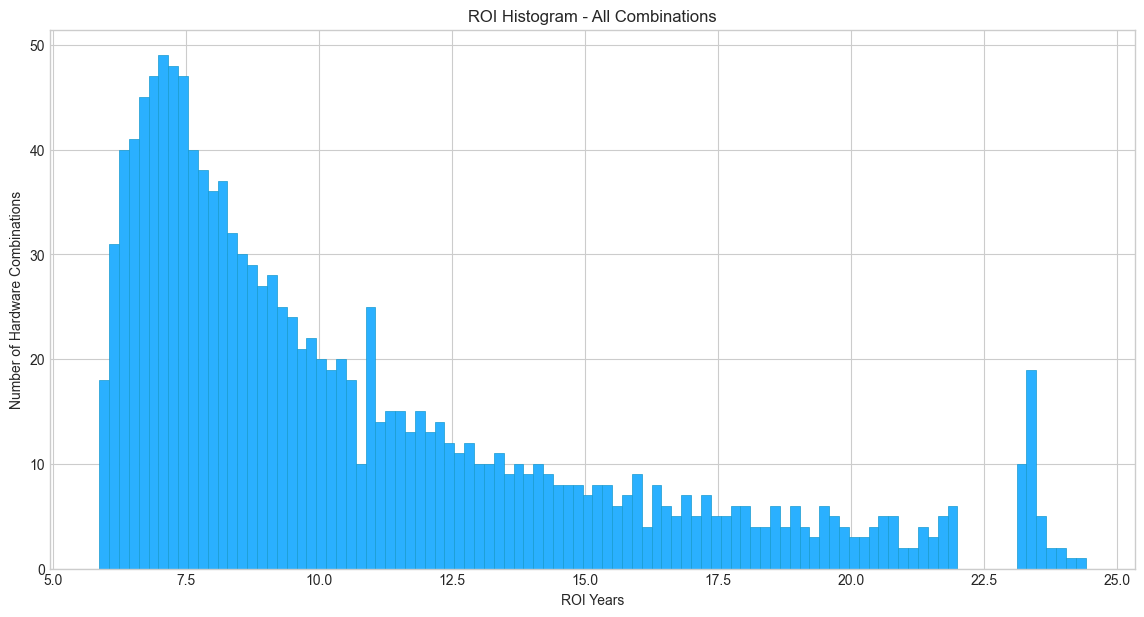

In [793]:
#ROI histogram

#n, bins, patches = plt.hist(df['roi'], 100, density=False, facecolor='g', alpha=0.75)

# Make it 14x7 inch
plt.figure(figsize=(14,7)) # Make it 14x7 inch
plt.style.use('seaborn-whitegrid') # nice and clean grid
plt.hist(df['roi'], bins=100, facecolor = '#2ab0ff', edgecolor='#169acf', linewidth=0.5)
plt.title('ROI Histogram - All Combinations') 
plt.xlabel('ROI Years') 
plt.ylabel('Number of Hardware Combinations') 
plt.show()

#style source: https://medium.com/@arseniytyurin/how-to-make-your-histogram-shine-69e432be39ca

463 hardware combinations with favorable ROI


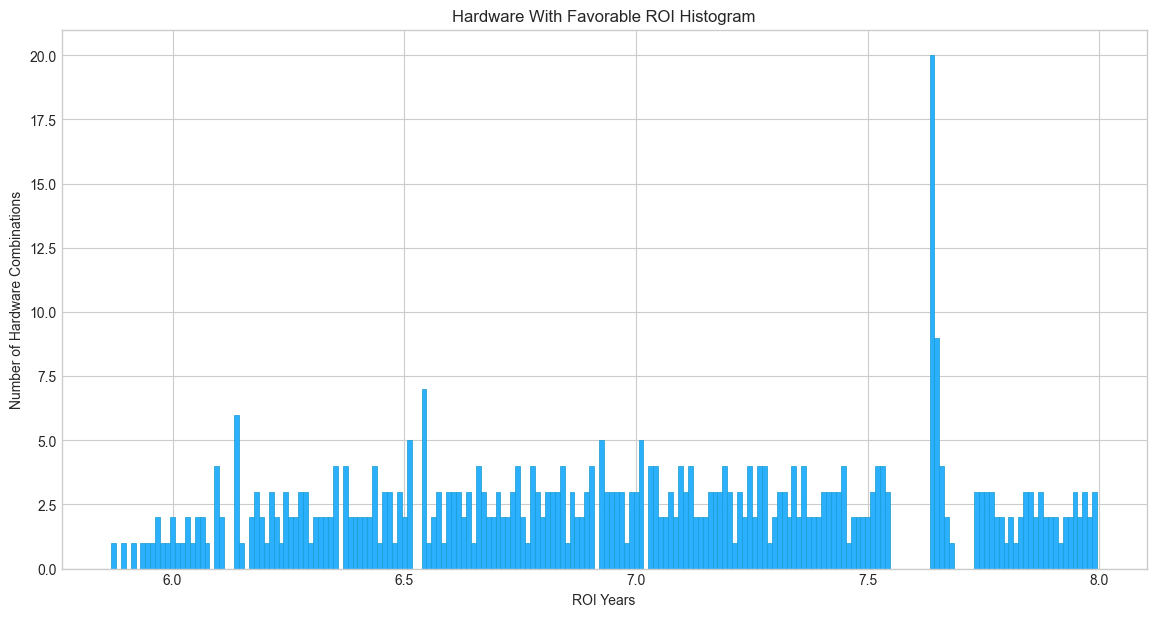

In [794]:
favROI_df = df[df['roi'] < 8] 

print(str(favROI_df.shape[0])+ ' hardware combinations with favorable ROI')

# Make it 14x7 inch
plt.figure(figsize=(14,7)) # Make it 14x7 inch
plt.style.use('seaborn-whitegrid') # nice and clean grid
plt.hist(favROI_df['roi'], bins=200, facecolor = '#2ab0ff', edgecolor='#169acf', linewidth=0.5)
plt.title('Hardware With Favorable ROI Histogram') 
plt.xlabel('ROI Years') 
plt.ylabel('Number of Hardware Combinations') 
plt.show()

<AxesSubplot:xlabel='batWh', ylabel='pvW'>

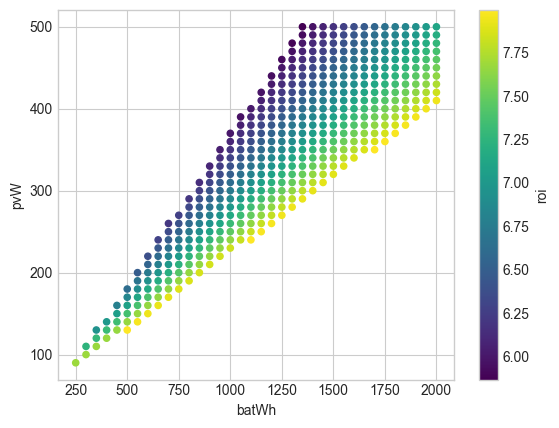

In [795]:
favROI_df.plot(kind = 'scatter', x = 'batWh', y = 'pvW', c='roi',colormap='viridis')

#df.show()

# df.savefig('foo.png')

# Results

### Most Favorable ROI

In [796]:
#most favorable ROI
favROI_df[favROI_df['roi'] == min(favROI_df['roi'])] 

,pvW,batWh,hardwareDollars,annualPVkWh,annualPVkWhAC,maxAutoParticipation,minParticipants,annualIncome,roi,avoidedGridCosts,drInc,drIncAnn
689,500,1350,1690.0,742.634028,712.928667,539.66778,93,288.05658,5.866903,190.91638,19.42804,97.1402


### PV System Range

In [797]:
#smallest PV system
favROI_df[favROI_df['pvW'] == min(favROI_df['pvW'])] 

,pvW,batWh,hardwareDollars,annualPVkWh,annualPVkWhAC,maxAutoParticipation,minParticipants,annualIncome,roi,avoidedGridCosts,drInc,drIncAnn
24,90,250,400.0,133.674125,128.32716,98.4842,508,52.092104,7.678707,34.364948,3.545431,17.727156


In [798]:
#largest PV systems
largePV = favROI_df[favROI_df['pvW'] == max(favROI_df['pvW'])] 
largePV

,pvW,batWh,hardwareDollars,annualPVkWh,annualPVkWhAC,maxAutoParticipation,minParticipants,annualIncome,roi,avoidedGridCosts,drInc,drIncAnn
689,500,1350,1690.0,742.634028,712.928667,539.66778,93,288.05658,5.866903,190.91638,19.42804,97.1402
739,500,1400,1730.0,742.634028,712.928667,549.26778,92,289.78458,5.969952,190.91638,19.77364,98.8682
789,500,1450,1770.0,742.634028,712.928667,558.86778,90,291.51258,6.071779,190.91638,20.11924,100.5962
839,500,1500,1810.0,742.634028,712.928667,568.46778,88,293.24058,6.172406,190.91638,20.46484,102.3242
889,500,1550,1850.0,742.634028,712.928667,578.06778,87,294.96858,6.271854,190.91638,20.81044,104.0522
939,500,1600,1890.0,742.634028,712.928667,587.66778,86,296.69658,6.370144,190.91638,21.15604,105.7802
989,500,1650,1930.0,742.634028,712.928667,597.26778,84,298.42458,6.467296,190.91638,21.50164,107.5082
1039,500,1700,1970.0,742.634028,712.928667,606.86778,83,300.15258,6.563329,190.91638,21.84724,109.2362
1089,500,1750,2010.0,742.634028,712.928667,616.46778,82,301.88058,6.658262,190.91638,22.19284,110.9642
1139,500,1800,2050.0,742.634028,712.928667,626.06778,80,303.60858,6.752115,190.91638,22.53844,112.6922


###  Battery System Range

In [799]:
#smallest Bat system
favROI_df[favROI_df['batWh'] == min(favROI_df['batWh'])] 

,pvW,batWh,hardwareDollars,annualPVkWh,annualPVkWhAC,maxAutoParticipation,minParticipants,annualIncome,roi,avoidedGridCosts,drInc,drIncAnn
24,90,250,400.0,133.674125,128.32716,98.4842,508,52.092104,7.678707,34.364948,3.545431,17.727156


In [800]:
#larget bat systems
favROI_df[favROI_df['batWh'] == max(favROI_df['batWh'])] 

,pvW,batWh,hardwareDollars,annualPVkWh,annualPVkWhAC,maxAutoParticipation,minParticipants,annualIncome,roi,avoidedGridCosts,drInc,drIncAnn
1330,410,2000,2120.0,608.959903,584.601507,613.983580,82,267.068476,7.938039,156.551431,22.103409,110.517044
1331,420,2000,2130.0,623.812583,598.860080,619.592936,81,271.896487,7.833864,160.369759,22.305346,111.526728
1332,430,2000,2140.0,638.665264,613.118653,625.202291,80,276.724499,7.733323,164.188086,22.507282,112.536412
1333,440,2000,2150.0,653.517944,627.377227,630.811647,80,281.552510,7.636231,168.006414,22.709219,113.546096
1334,450,2000,2160.0,668.370625,641.635800,636.421002,79,286.380522,7.542412,171.824742,22.911156,114.555780
1335,460,2000,2170.0,683.223306,655.894373,642.030358,78,291.208534,7.451705,175.643069,23.113093,115.565464
1336,470,2000,2180.0,698.075986,670.152947,647.639714,78,296.036545,7.363956,179.461397,23.315030,116.575148
1337,480,2000,2190.0,712.928667,684.411520,653.249069,77,300.864557,7.279023,183.279724,23.516966,117.584832
1338,490,2000,2200.0,727.781347,698.670093,658.858425,76,305.692568,7.196773,187.098052,23.718903,118.594516
1339,500,2000,2210.0,742.634028,712.928667,664.467780,76,310.520580,7.117081,190.916380,23.920840,119.604200


### Largest System

In [801]:
#largest overall system
largestSystem = largePV[largePV['batWh'] == max(largePV['batWh'])] 
largestSystem

,pvW,batWh,hardwareDollars,annualPVkWh,annualPVkWhAC,maxAutoParticipation,minParticipants,annualIncome,roi,avoidedGridCosts,drInc,drIncAnn
1339,500,2000,2210.0,742.634028,712.928667,664.46778,76,310.52058,7.117081,190.91638,23.92084,119.6042


### Upfront Costs

In [802]:
#cheapest upfront cost
favROI_df[favROI_df['hardwareDollars'] == min(favROI_df['hardwareDollars'])] 

,pvW,batWh,hardwareDollars,annualPVkWh,annualPVkWhAC,maxAutoParticipation,minParticipants,annualIncome,roi,avoidedGridCosts,drInc,drIncAnn
24,90,250,400.0,133.674125,128.32716,98.4842,508,52.092104,7.678707,34.364948,3.545431,17.727156


In [803]:
#most expensive upfront cost
favROI_df[favROI_df['hardwareDollars'] == max(favROI_df['hardwareDollars'])] 

,pvW,batWh,hardwareDollars,annualPVkWh,annualPVkWhAC,maxAutoParticipation,minParticipants,annualIncome,roi,avoidedGridCosts,drInc,drIncAnn
1339,500,2000,2210.0,742.634028,712.928667,664.46778,76,310.52058,7.117081,190.91638,23.92084,119.6042


### DR Impact

In [804]:
#best automated DR contribution
favROI_df[favROI_df['maxAutoParticipation'] == max(favROI_df['maxAutoParticipation'])] 

,pvW,batWh,hardwareDollars,annualPVkWh,annualPVkWhAC,maxAutoParticipation,minParticipants,annualIncome,roi,avoidedGridCosts,drInc,drIncAnn
1339,500,2000,2210.0,742.634028,712.928667,664.46778,76,310.52058,7.117081,190.91638,23.92084,119.6042


In [805]:
#worst DR contribution
favROI_df[favROI_df['maxAutoParticipation'] == min(favROI_df['maxAutoParticipation'])] 


,pvW,batWh,hardwareDollars,annualPVkWh,annualPVkWhAC,maxAutoParticipation,minParticipants,annualIncome,roi,avoidedGridCosts,drInc,drIncAnn
24,90,250,400.0,133.674125,128.32716,98.4842,508,52.092104,7.678707,34.364948,3.545431,17.727156


In [806]:
#ratio of DR income to avoided electricity costs
incRatio = favROI_df['avoidedGridCosts'] / favROI_df['drIncAnn']

print('Ratio of financial benefits (avoided grid costs/ DR income)')
print('Min: ' + str(min(incRatio)))
print('Max: ' + str(max(incRatio)))

      #how many DR participants are required to meet the minimum requirements?

Ratio of financial benefits (avoided grid costs/ DR income)
Min: 1.4165365365255909
Max: 1.9680624458383023


### Greatest Income after ROI is reached up to EOL

In [830]:
# income from ROI to EOL 
# iar = income after return

eol = avgBatCycles / 365
       
print("Avg Cycles in Years: " + str(eol))
print('')

favROI_df['iar'] = (eol - favROI_df['roi']) * favROI_df['annualIncome']

print(max(favROI_df['iar']))

favROI_df[favROI_df['iar'] == max(favROI_df['iar'])] 

'''
minIar = round(min(favROI_df['iar'])*100)*.01
print("Minimum IAR: $" + str(minIar) + " ($" + str(minIar/10) + "/yr for 10 years)")
maxIar = round(max(favROI_df['iar'])*100)*.01
print("Maximum IAR: $" + str(maxIar) + " ($" + str(maxIar/10) + "/yr for 10 years)")
'''

Avg Cycles in Years: 8.493150684931507

756.5079404231407


C:\Users\Alex\AppData\Local\Programs\Python\Python37\lib\site-packages\ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == "__main__":


'\nminIar = round(min(favROI_df[\'iar\'])*100)*.01\nprint("Minimum IAR: $" + str(minIar) + " ($" + str(minIar/10) + "/yr for 10 years)")\nmaxIar = round(max(favROI_df[\'iar\'])*100)*.01\nprint("Maximum IAR: $" + str(maxIar) + " ($" + str(maxIar/10) + "/yr for 10 years)")\n'

In [812]:
iar_df

24       42.426092
34       48.107287
35       79.112317
46       53.788481
47       84.793511
           ...    
1335    303.277957
1336    334.282987
1337    365.288017
1338    396.293047
1339    427.298077
Length: 463, dtype: float64

# Discussion

Operational costs may be able to be met from the DR income after ROI has been reached

* What is the income from the point of ROI to end of life?

In [808]:
# Notes

looks at micro adjustments - exactly because of small amounts of energy

software diagram!

battery stuff for Koushick

value of resiliency? 

SyntaxError: invalid syntax (539148002.py, line 3)